In [1]:
from pyntcloud import PyntCloud
from pyntcloud.io import bin as io_bin
import numpy as np
import pandas as pd
import os

In [6]:
VELODYNE_HEIGHT = 3

def extractBB(label,gt=True):
    label_split = label.split(" ")
    if gt:
        return label_split[0],float(label_split[-7]),float(label_split[-6]),float(label_split[-5]),float(label_split[-4]),float(label_split[-3]),float(label_split[-2]),float(label_split[-1])
    else:
        return label_split[0],float(label_split[-8]),float(label_split[-7]),float(label_split[-6]),float(label_split[-5]),float(label_split[-4]),float(label_split[-3]),float(label_split[-2])
    
def getCorners(height,width,length,x,y,z,θ,rotation=True):
    
    corners = np.array([[-length / 2, -length / 2, length / 2, length / 2, -length / 2, -length / 2, length / 2, length / 2],
                        [width / 2, -width / 2, -width / 2, width / 2, width / 2, -width / 2, -width / 2, width / 2],
                        [0, 0, 0, 0, height, height, height, height]])
    
    rotMat = np.array([[np.cos(θ) , -np.sin(θ) , 0],
                       [np.sin(θ) ,  np.cos(θ) , 0],
                       [    0     ,     0      , 1]])
    if rotation:
        cornersPos = (np.dot(rotMat,corners)+np.tile([x,y,z],(8,1)).T).transpose()
        corner1,corner2,corner3,corner4,corner5,corner6,corner7,corner8 = cornersPos[0],cornersPos[1],cornersPos[2],cornersPos[3],cornersPos[4],cornersPos[5],cornersPos[6],cornersPos[7]
    else:
        cornersPos = (corners + np.tile([x,y,z],(8,1)).T).transpose()
        corner1,corner2,corner3,corner4,corner5,corner6,corner7,corner8 = cornersPos[0],cornersPos[1],cornersPos[2],cornersPos[3],cornersPos[4],cornersPos[5],cornersPos[6],cornersPos[7]
    
    return list(corner1),list(corner2),list(corner3),list(corner4),list(corner5),list(corner6),list(corner7),list(corner8)

def createBBox(bounding_box,C1,C2,C3,C4,C5,C6,C7,C8,color="yellow"):
    bounding_box.append(
        {
            "color":color,
            "vertices":[C1,C2,C3,C4,C1]
        })
    bounding_box.append(
        {
            "color":color,
            "vertices":[C1,C4,C8,C5,C1]
        })
    bounding_box.append(
        {
            "color":color,
            "vertices":[C1,C2,C6,C5,C1]
        })
    bounding_box.append(
        {
            "color":color,
            "vertices":[C2,C6,C7,C3,C2]
        })
    bounding_box.append(
        {
            "color":color,
            "vertices":[C3,C7,C8,C4,C3]
        })
    return bounding_box

## Display Ground Truth & PointRCNN predictions

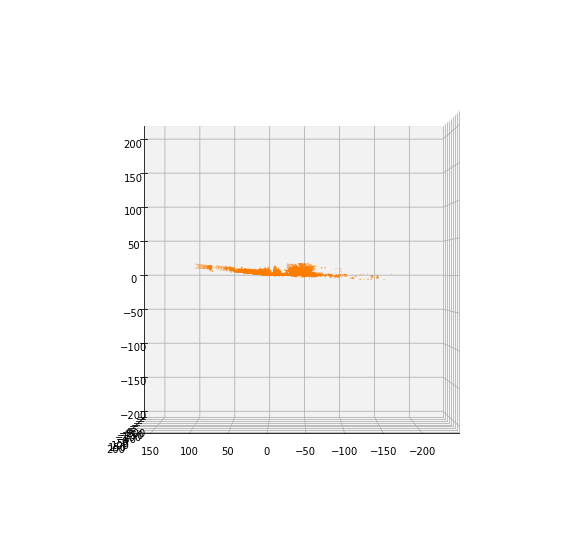

In [11]:
KITTI_PATH = "/media/jionie/my_disk/Kaggle/Lyft/input/3d-object-detection-for-autonomous-vehicles/train_root/KITTI/"
PC_ID = "30d4d496e0393f90aeaa910b21761a8fc07ce8b733cc81185041e3139110f793"
points = io_bin.read_bin(KITTI_PATH+"velodyne/"+PC_ID+".bin",shape=(-1,4))['points']
points['z'] += VELODYNE_HEIGHT

assert os.path.exists(KITTI_PATH+"label_2/"+PC_ID+".txt"), "File "+KITTI_PATH+"label_2/"+PC_ID+".txt doesn't exist !"
file_label_gt = open(KITTI_PATH+"label_2/"+PC_ID+".txt","r")
labels_gt = file_label_gt.readlines()
file_label_gt.close()

labels_clean_gt = []
for i,label in enumerate(labels_gt):
    labels_gt[i]=label[:-2]
    if labels_gt[i].split(" ")[0] in ["car", "Van", "truck"]:
        labels_clean_gt.append(extractBB(labels_gt[i],gt=True))
        
bounding_box = []
colors = {"GT":'blue',"Pred":"yellow"}

for label in labels_clean_gt: 
    object_type,height,width,length,x_tmp,y_tmp,z_tmp,θ = label
    x,y,z,θ = z_tmp,-x_tmp,y_tmp-VELODYNE_HEIGHT,np.pi/2-θ
    C1,C2,C3,C4,C5,C6,C7,C8 = getCorners(height,width,length,x,y,z,θ,rotation=True)
    bounding_box = createBBox(bounding_box,C1,C2,C3,C4,C5,C6,C7,C8,colors["GT"])
    
    
cloud = PyntCloud(points)
cloud.plot(initial_point_size=0.02, polylines=bounding_box)

In [3]:
KITTI_PATH = "/home/data/KITTI/Original/training/"
PointRCNN_PATH = "/home/data/CTI1/lego//PointCloudObjectDetection/PointRCNN/pretrained_model/final_result/data/"

PC_ID = '%06d' % 6388 # [0 : 7480] 

points = io_bin.read_bin(KITTI_PATH+"velodyne/"+PC_ID+".bin",shape=(-1,4))['points']
points['z'] += VELODYNE_HEIGHT

assert os.path.exists(KITTI_PATH+"label_2/"+PC_ID+".txt"), "File "+KITTI_PATH+"label_2/"+PC_ID+".txt doesn't exist !"
file_label_gt = open(KITTI_PATH+"label_2/"+PC_ID+".txt","r")
labels_gt = file_label_gt.readlines()
file_label_gt.close()

assert os.path.exists(PointRCNN_PATH+PC_ID+".txt"), "File "+PointRCNN_PATH+PC_ID+".txt doesn't exist !"
file_label_pred = open(PointRCNN_PATH+PC_ID+".txt","r")
labels_pred = file_label_pred.readlines()
file_label_pred.close()

labels_clean_gt = []
for i,label in enumerate(labels_gt):
    labels_gt[i]=label[:-2]
    if labels_gt[i].split(" ")[0] in ["Car", "Van", "Truck"]:
        labels_clean_gt.append(extractBB(labels_gt[i],gt=True))

labels_clean_pred = []
for i,label in enumerate(labels_pred):
    labels_pred[i]=label[:-2]
    if labels_pred[i].split(" ")[0] == "Car":
        labels_clean_pred.append(extractBB(labels_pred[i],gt=False))

bounding_box = []
colors = {"GT":'blue',"Pred":"yellow"}

for label in labels_clean_gt: 
    object_type,height,width,length,x_tmp,y_tmp,z_tmp,θ = label
    x,y,z,θ = z_tmp,-x_tmp,y_tmp-VELODYNE_HEIGHT,np.pi/2-θ
    C1,C2,C3,C4,C5,C6,C7,C8 = getCorners(height,width,length,x,y,z,θ,rotation=True)
    bounding_box = createBBox(bounding_box,C1,C2,C3,C4,C5,C6,C7,C8,colors["GT"])
    
for label in labels_clean_pred: 
    object_type,height,width,length,x_tmp,y_tmp,z_tmp,θ = label
    x,y,z,θ = z_tmp,-x_tmp,y_tmp-VELODYNE_HEIGHT,np.pi/2-θ
    C1,C2,C3,C4,C5,C6,C7,C8 = getCorners(height,width,length,x,y,z,θ,rotation=True)
    bounding_box = createBBox(bounding_box,C1,C2,C3,C4,C5,C6,C7,C8,colors["Pred"])
    
    
cloud = PyntCloud(points)
cloud.plot(initial_point_size=0.02, polylines=bounding_box)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-1.290243148803711, 55.121368646621704, 7.58…